## Problem Statement

### JanataHack: Cross-Sell Prediction

#### Objective

Cross-Sell Prediction
Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

## Evaluation Metric
### The evaluation metric for this hackathon is ROC_AUC score.

In [235]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from xgboost                          import XGBClassifier
from catboost                         import CatBoostClassifier, Pool
from lightgbm                         import LGBMClassifier

import warnings
warnings.filterwarnings('ignore');

In [237]:
# read the data
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [238]:
# total no.of rows and columns
train.shape, test.shape

((381109, 12), (127037, 11))

In [241]:
# To see columns of train dataset
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [243]:
# To see first few data points in the dataset
train.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

In [245]:
# check the data frame info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [247]:
# to check missing values
train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [249]:
# to see columnnames as its datatype
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [251]:
# to check duplicates
train.duplicated().sum()

0

In [253]:
# check target data
train['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [255]:
# how much percentage of Imbalanced data available in the given dataset
train.Response.value_counts(normalize=True)*100

Response
0    87.743664
1    12.256336
Name: proportion, dtype: float64

<Axes: xlabel='Response'>

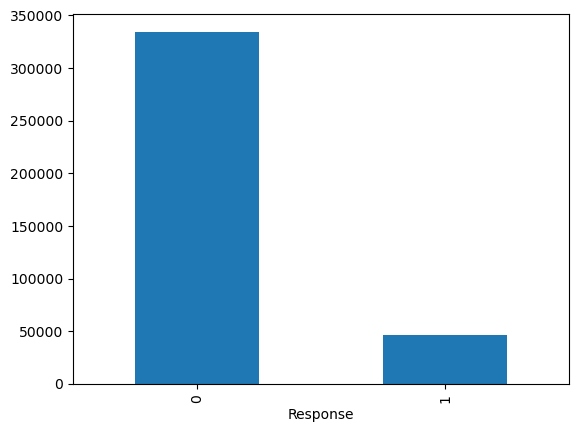

In [257]:
train.Response.value_counts().plot(kind='bar')

In [259]:
# statistical info

train.describe().T

count           mean            std     min      25%  \
id                    381109.0  190555.000000  110016.836208     1.0  95278.0   
Age                   381109.0      38.822584      15.511611    20.0     25.0   
Driving_License       381109.0       0.997869       0.046110     0.0      1.0   
Region_Code           381109.0      26.388807      13.229888     0.0     15.0   
Previously_Insured    381109.0       0.458210       0.498251     0.0      0.0   
Annual_Premium        381109.0   30564.389581   17213.155057  2630.0  24405.0   
Policy_Sales_Channel  381109.0     112.034295      54.203995     1.0     29.0   
Vintage               381109.0     154.347397      83.671304    10.0     82.0   
Response              381109.0       0.122563       0.327936     0.0      0.0   

                           50%       75%       max  
id                    190555.0  285832.0  381109.0  
Age                       36.0      49.0      85.0  
Driving_License            1.0       1.0       1.0  
Region_Code               28.0      35.0      52.0  
Previously_Insured         0.0       1.0       1.0  
Annual_Premium         31669.0   39400.0  540165.0  
Policy_Sales_Channel     133.0     152.0     163.0  
Vintage                  154.0     227.0     299.0  
Response                   0.0       0.0       1.0

In [261]:
train.describe(include='object').T

count unique       top    freq
Gender          381109      2      Male  206089
Vehicle_Age     381109      3  1-2 Year  200316
Vehicle_Damage  381109      2       Yes  192413

In [263]:
train.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

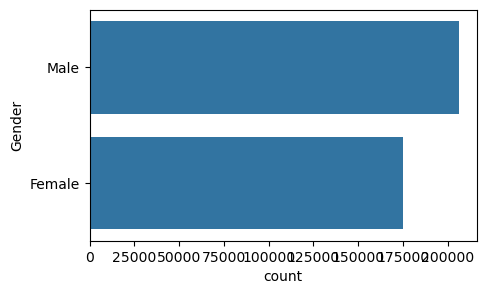

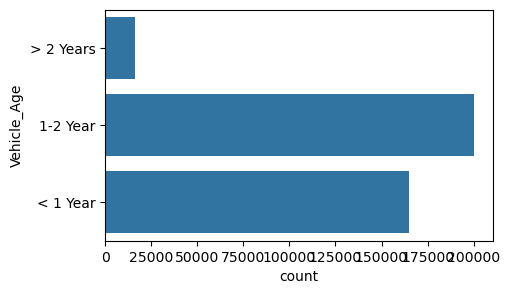

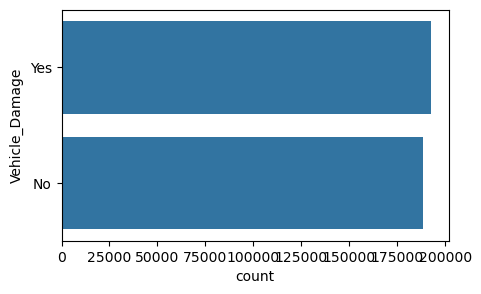

In [265]:
for col in train.select_dtypes(include='object').columns:
    plt.figure(figsize=(5,3))
    sns.countplot(y=train[col])
    plt.show()

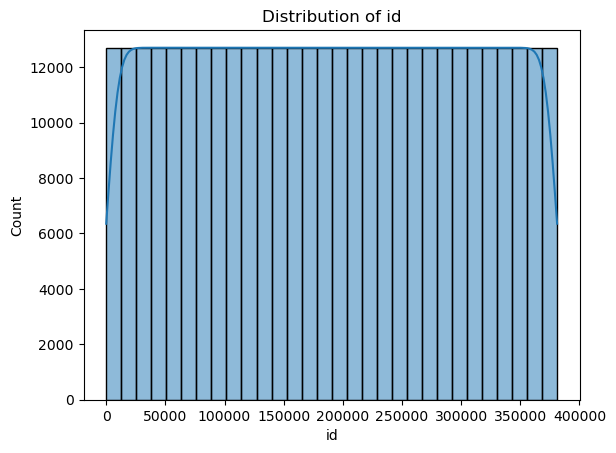

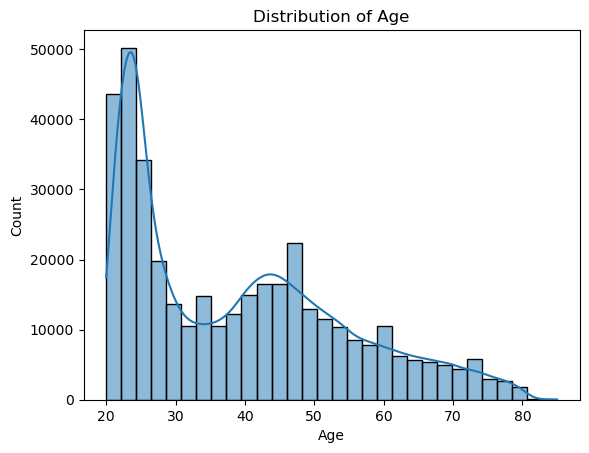

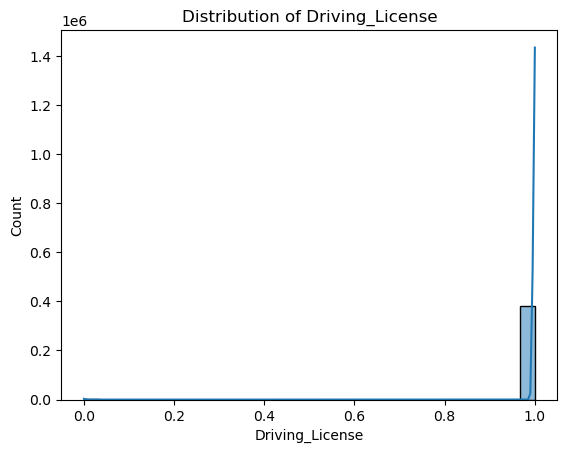

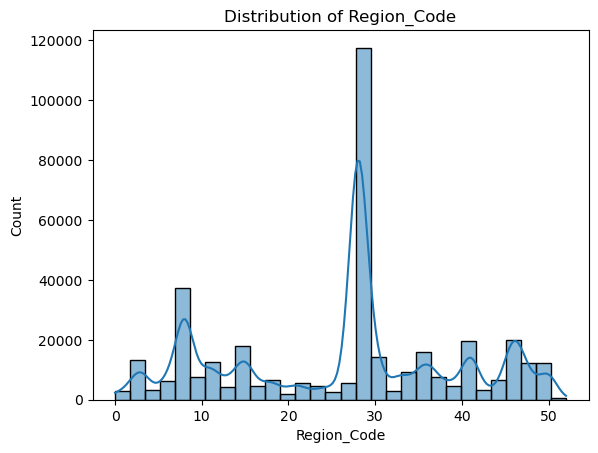

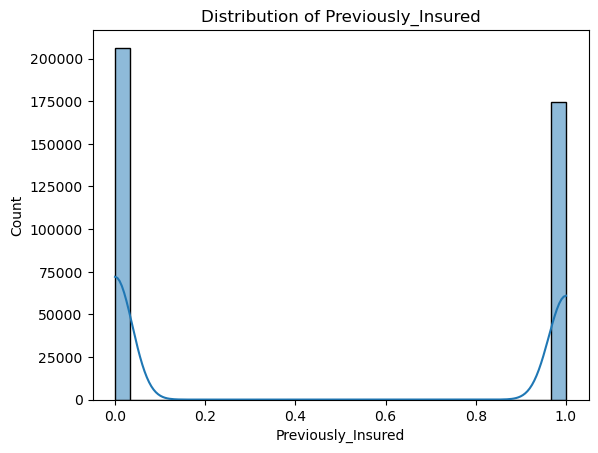

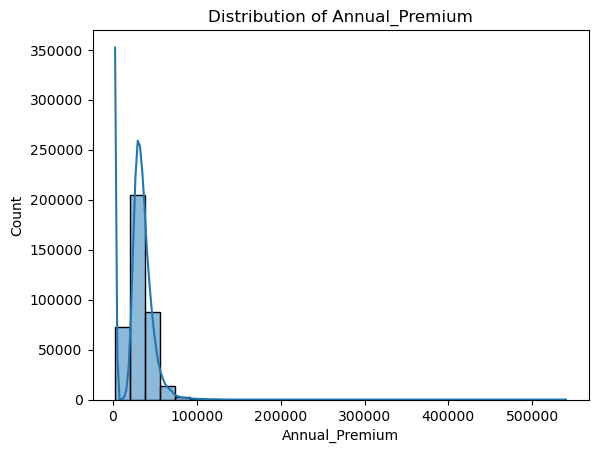

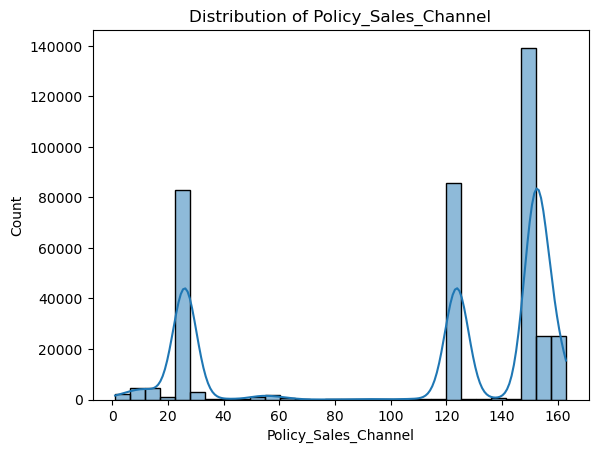

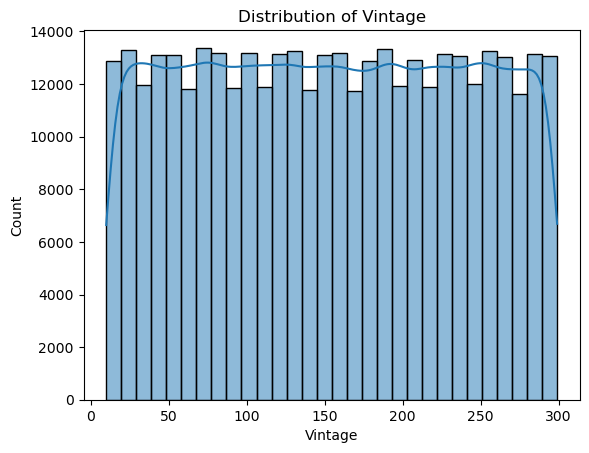

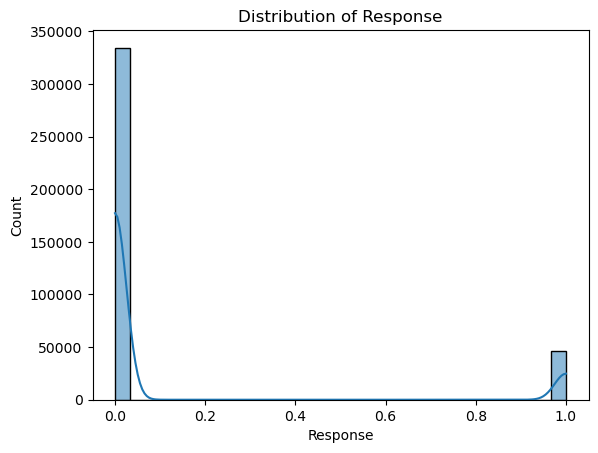

In [279]:
# Visualize distributions
for column in train.select_dtypes(exclude='object').columns:
    sns.histplot(train[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.show()

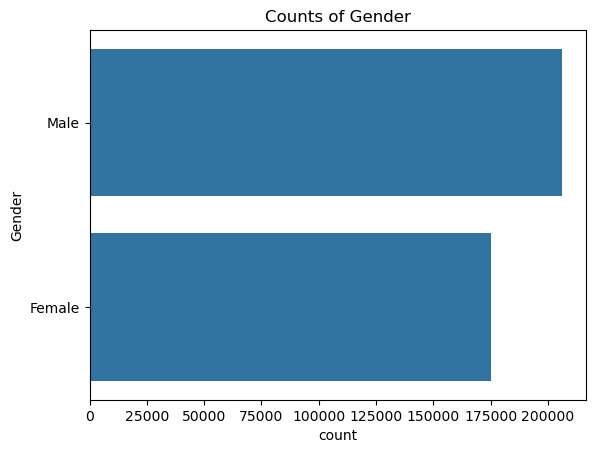

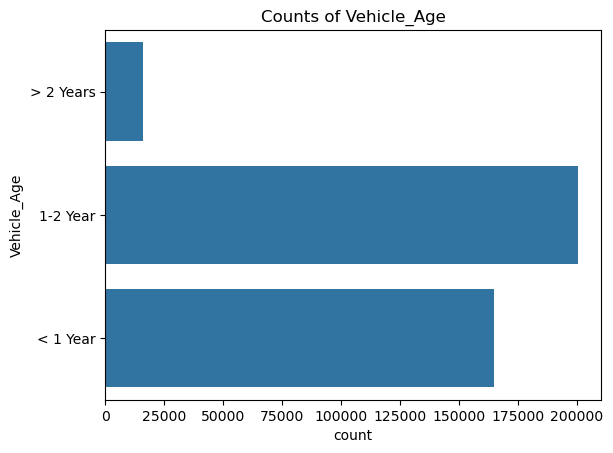

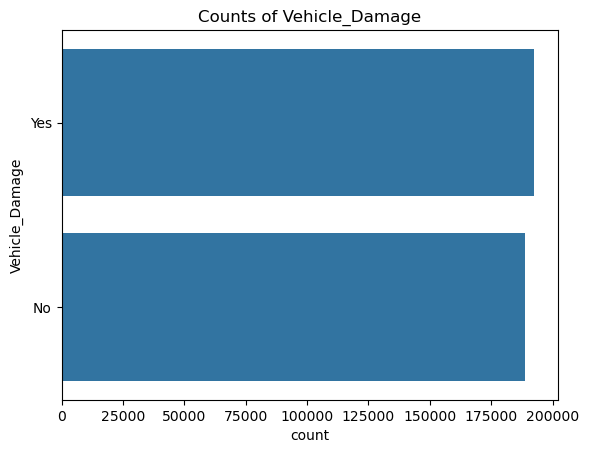

In [280]:
# Univariate analysis
categorical_columns = train.select_dtypes(include=['object']).columns
for column in categorical_columns:
    sns.countplot(train[column])
    plt.title(f'Counts of {column}')
    plt.show()

In [281]:
# converting object to int type :
# train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
# train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
# train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})

In [282]:
# identify cols
tgt_col=['Response']
ign_cols = ['id']
cat_cols = train.select_dtypes(include='object').columns
num_cols = train.select_dtypes(exclude='object').columns

In [283]:
print(tgt_col, ign_cols, cat_cols, num_cols,sep='\n')

['Response']
['id']
Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [284]:
train[cat_cols].head(2)

Gender Vehicle_Age Vehicle_Damage
0   Male   > 2 Years            Yes
1   Male    1-2 Year             No

In [285]:
# to see numerical columns after removing the target columns and not required columns
num_cols=train.select_dtypes(exclude='object').drop(columns=ign_cols+tgt_col).columns
train[num_cols].head(2)

Age  Driving_License  Region_Code  Previously_Insured  Annual_Premium  \
0   44                1         28.0                   0         40454.0   
1   76                1          3.0                   0         33536.0   

   Policy_Sales_Channel  Vintage  
0                  26.0      217  
1                  26.0      183

In [286]:
# check unique values

for col in train.drop(columns=ign_cols).columns:
    print(col,train[col].nunique(),  '=>', train[col].unique())

Gender 2 => ['Male' 'Female']
Age 66 => [44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]
Driving_License 2 => [1 0]
Region_Code 53 => [28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]
Previously_Insured 2 => [0 1]
Vehicle_Age 3 => ['> 2 Years' '1-2 Year' '< 1 Year']
Vehicle_Damage 2 => ['Yes' 'No']
Annual_Premium 48838 => [ 40454.  33536.  38294. ...  20706. 101664.  69845.]
Policy_Sales_Channel 155 => [ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  15.
 154.  16.  52. 155.  11. 151. 125.  25.  61.   1.  86.  31. 150.  23.
  60.  21. 121.   3. 139.  12.  29.  55.   7.  47. 127. 153.  78. 158.
  89.  32.   8.  10. 120.  65.   4.  42.  83. 136.  24.  18.  

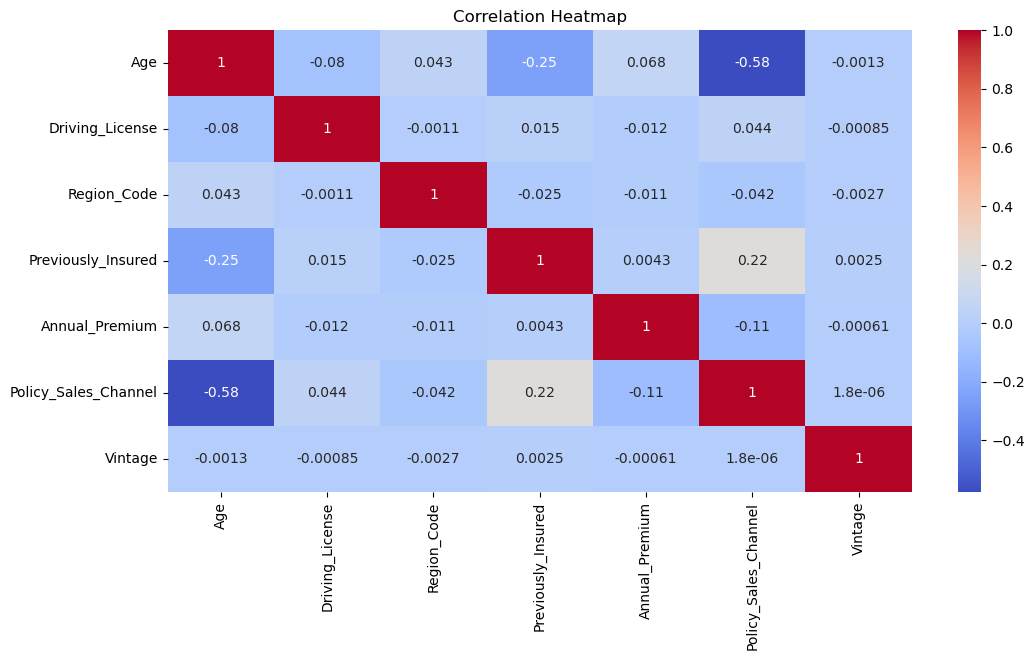

In [287]:
# Bivariate analysis
plt.figure(figsize=(12,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

<Figure size 1200x600 with 0 Axes>

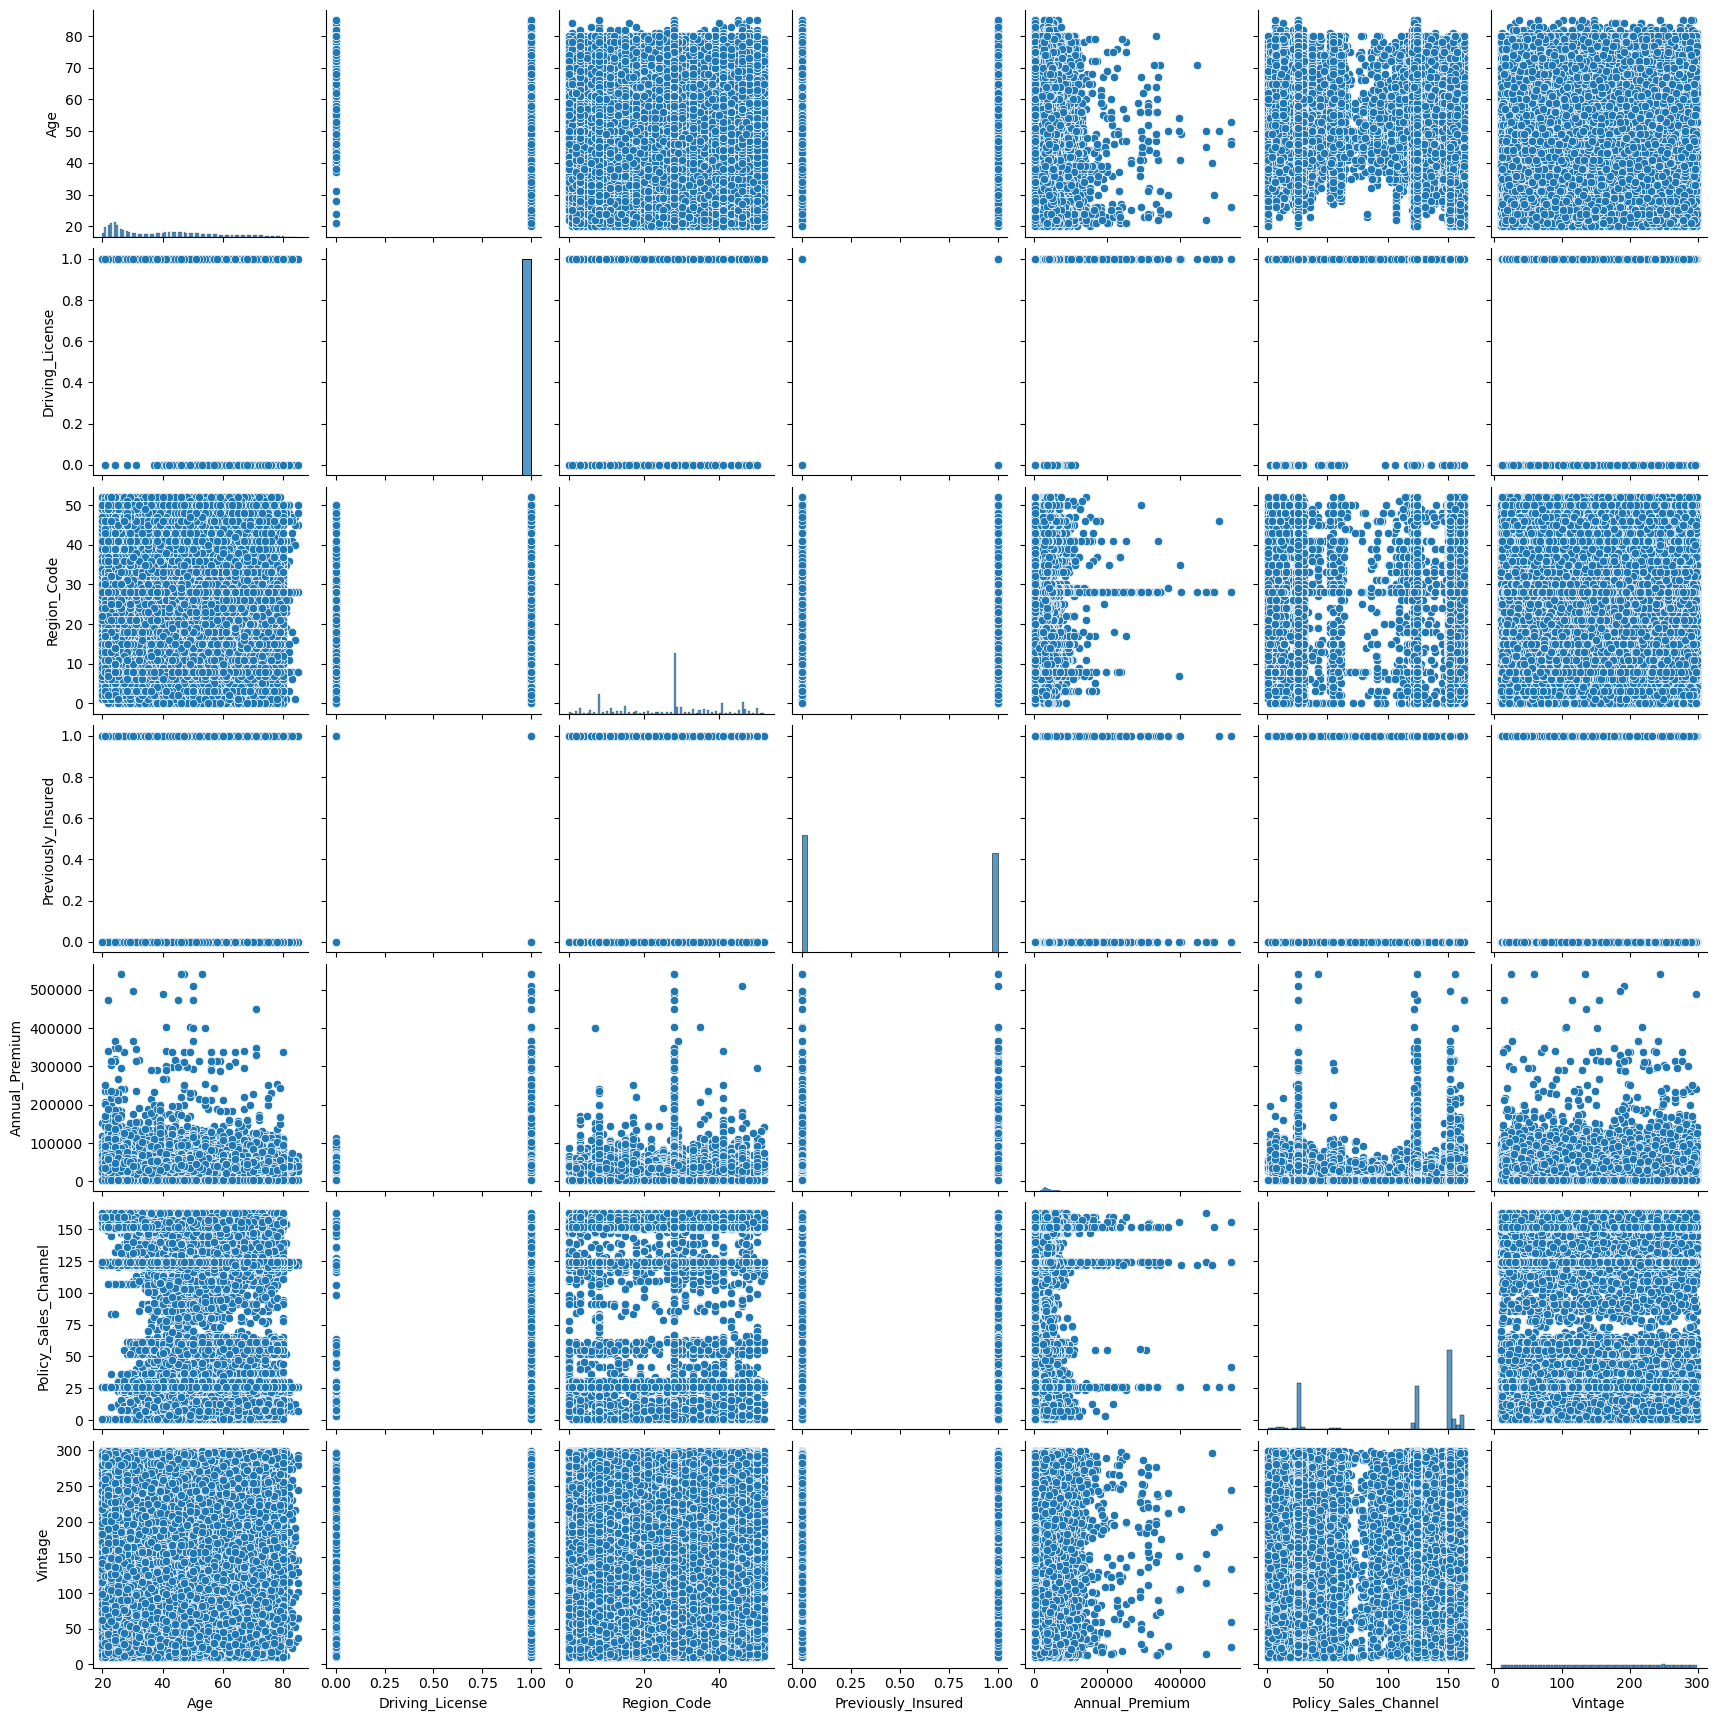

In [288]:
#Bivariate
plt.figure(figsize=(12,6))
sns.pairplot(train[num_cols])

In [289]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# Custom transformer for manual mapping of categorical columns
class CategoricalMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mappings = {
            'Vehicle_Age': {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
            'Gender': {'Male': 1, 'Female': 0},
            'Vehicle_Damage': {'Yes': 1, 'No': 0}
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col, mapping in self.mappings.items():
            if col in X.columns:
                X[col] = X[col].replace(mapping)
        return X

    def fit_transform(self, X, y=None):
        print("Fit_transform called in CustomTransformer...")  # Debug message
        self.fit(X, y)
        return self.transform(X)

### Pipeline

In [295]:
# create pipeline to do preprocessing of category columns
cat_pipe_encode = Pipeline(
    steps = [
        ('impute_cat', SimpleImputer(strategy = 'most_frequent')),  # missing values
        # ('mapper', CategoricalMapper()),  # Apply the custom mapping
        ('ohe', OneHotEncoder(handle_unknown='ignore')) # category encoding
    ]
)

In [302]:
# create pipeline to perform preprocessing of numerical columns
num_pipe_encode = Pipeline(
    steps = [
        ('impute_num',SimpleImputer(strategy = 'median'))   ,   # missing values
        ('scale',StandardScaler())      # standard scaler
    ]
)

In [303]:
# create map between the pipeline and the columns
preprocess = ColumnTransformer(
    transformers = [
        ('cat_encode', cat_pipe_encode, cat_cols)    ,  # categorical columns
        ('num_encode', num_pipe_encode, num_cols)    # numerical columns
    ]
)

In [304]:
mymodel = LogisticRegression()

In [305]:
# merging the preprocessing and modelling in a pipeline
model_pipeline = Pipeline(
    steps = [
        ('preprocess', preprocess), # preprocessing
        ('model', mymodel) # modelling
    ]
)

In [306]:
# split the train dataset to train and validation
X = train.drop(columns = ign_cols+tgt_col)
X.head(2)

Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age  \
0   Male   44                1         28.0                   0   > 2 Years   
1   Male   76                1          3.0                   0    1-2 Year   

  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  
0            Yes         40454.0                  26.0      217  
1             No         33536.0                  26.0      183

In [307]:
y = train[tgt_col]
y.head(2)

Response
0         1
1         0

In [308]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 42)
train_X.shape, val_X.shape, train_y.shape, val_y.shape

((304887, 10), (76222, 10), (304887, 1), (76222, 1))

In [309]:
train.shape, int(train.shape[0]*.8), int(train.shape[0]*.2)

((381109, 12), 304887, 76221)

In [310]:
# fit the model
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('model', LogisticRegression())])

In [311]:
# perform prediction with train itself
model_pipeline.predict(train_X)

array([0, 0, 0, ..., 0, 0, 0])

In [312]:
# predict target 

model_pipeline.predict(val_X)

array([0, 0, 0, ..., 0, 0, 0])

In [313]:
# predict target with probability

model_pipeline.predict_proba(val_X)

array([[9.99565065e-01, 4.34935063e-04],
       [7.21418102e-01, 2.78581898e-01],
       [6.87708961e-01, 3.12291039e-01],
       ...,
       [9.99597158e-01, 4.02842245e-04],
       [9.99550777e-01, 4.49223458e-04],
       [9.99503407e-01, 4.96593053e-04]])

In [314]:
model_pipeline.predict_proba(val_X)[:,0]

array([0.99956506, 0.7214181 , 0.68770896, ..., 0.99959716, 0.99955078,
       0.99950341])

In [315]:
model_pipeline.predict_proba(val_X)[:,1]

array([0.00043494, 0.2785819 , 0.31229104, ..., 0.00040284, 0.00044922,
       0.00049659])

In [333]:
# evaluation method

def model_train_val_eval(train_X,val_X,train_y,val_y,model_pipeline):
    
    predicted_train_tgt = model_pipeline.predict(train_X)
    predicted_val_tgt = model_pipeline.predict(val_X)
    
    print("Train Accuracy : ",accuracy_score(train_y, predicted_train_tgt),sep='\n')
    print("Test Accuracy : ",accuracy_score(val_y, predicted_val_tgt),sep='\n')

    print('Train AUC', roc_auc_score(train_y,predicted_train_tgt),sep='\n')
    print('Valid AUC', roc_auc_score(val_y,predicted_val_tgt),sep='\n')

    print('Train cnf_matrix', confusion_matrix(train_y,predicted_train_tgt),sep='\n')
    print('Valid cnf_matrix', confusion_matrix(val_y,predicted_val_tgt),sep='\n')

    print('Train cls_rep', classification_report(train_y,predicted_train_tgt),sep='\n')
    print('Valid cls rep', classification_report(val_y,predicted_val_tgt),sep='\n')

    # plot roc-auc
    y_pred_proba = model_pipeline.predict_proba(val_X)[:,1]
    plt.figure()
    fpr, tpr, thrsh = roc_curve(val_y,y_pred_proba)

    #roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr)
    plt.show()

Train Accuracy : 
0.8780269411290085
Test Accuracy : 
0.8750623179659416
Train AUC
0.500067599016647
Valid AUC
0.5
Train cnf_matrix
[[267693      7]
 [ 37181      6]]
Valid cnf_matrix
[[66699     0]
 [ 9523     0]]
Train cls_rep
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    267700
           1       0.46      0.00      0.00     37187

    accuracy                           0.88    304887
   macro avg       0.67      0.50      0.47    304887
weighted avg       0.83      0.88      0.82    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.00      0.00      0.00      9523

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



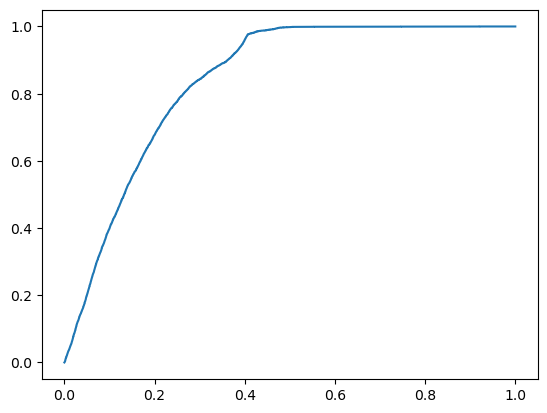

In [335]:
model_train_val_eval(train_X,val_X,train_y,val_y,model_pipeline)

## Using GridSearch to hyper tune single model

In [338]:
# set the hyper parameters

params = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    }    
]

In [340]:
# map the grid parameters with pipeline

grid = GridSearchCV(estimator=model_pipeline, param_grid=params, 
                    cv=2, scoring='roc_auc', verbose=2)

In [342]:
grid.fit(train_X, train_y)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l2, model__solver=saga; total time=   3.0s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l2, model__solver=saga; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   0.8s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   0.8s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   2.9s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   0.8s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   0.7s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                                       ('model', LogisticRegression())]),
             param_grid=[{'model': [LogisticRegression()], 'model__C': [0.5, 3],
                          'model__penalty': ['l2', None],
                          'model__solver': ['saga']}],
             scoring='roc_auc', verbose=2)

In [343]:
# get the best parameter

grid.best_params_

{'model': LogisticRegression(),
 'model__C': 0.5,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [344]:
grid.cv_results_

{'mean_fit_time': array([2.78454852, 0.67221069, 2.75592875, 0.64101088]),
 'std_fit_time': array([0.12251234, 0.00870466, 0.03514147, 0.02857816]),
 'mean_score_time': array([0.09063554, 0.10903192, 0.09808946, 0.09914756]),
 'std_score_time': array([0.00040936, 0.01892996, 0.00046945, 0.00081444]),
 'param_model': masked_array(data=[LogisticRegression(), LogisticRegression(),
                    LogisticRegression(), LogisticRegression()],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__C': masked_array(data=[0.5, 0.5, 3.0, 3.0],
              mask=[False, False, False, False],
        fill_value=1e+20),
 'param_model__penalty': masked_array(data=['l2', None, 'l2', None],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__solver': masked_array(data=['saga', 'saga', 'saga', 'saga'],
              mask=[False, False, False, False],
        fill_value='?',

In [345]:
# show the grid results

res_df = pd.DataFrame(grid.cv_results_,)
pd.set_option('display.max_colwidth',100)
res_df[['params','mean_test_score','rank_test_score']]

params  \
0  {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1  {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2    {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3    {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   

   mean_test_score  rank_test_score  
0         0.835767                1  
1         0.835766                4  
2         0.835766                2  
3         0.835766                3

## Sample submission without modeling

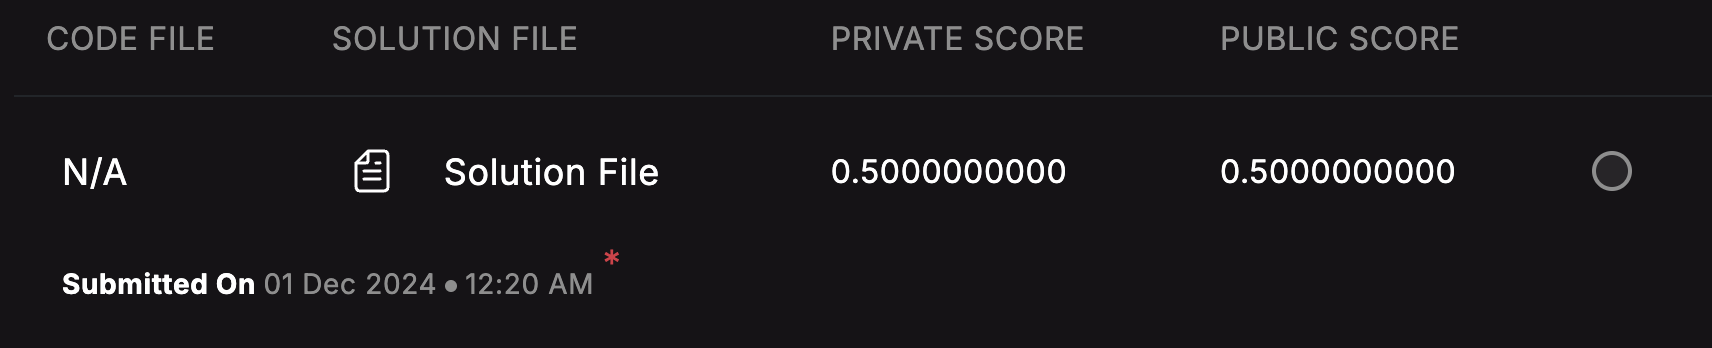

In [348]:
train.columns.difference(test.columns)

Index(['Response'], dtype='object')

In [349]:
sub = pd.read_csv('sample_submission_iA3afxn.csv')
sub['Response'] = model_pipeline.predict(test)
sub.to_csv('sub_1.csv',index=False)

In [350]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Submission of sub_1.csv

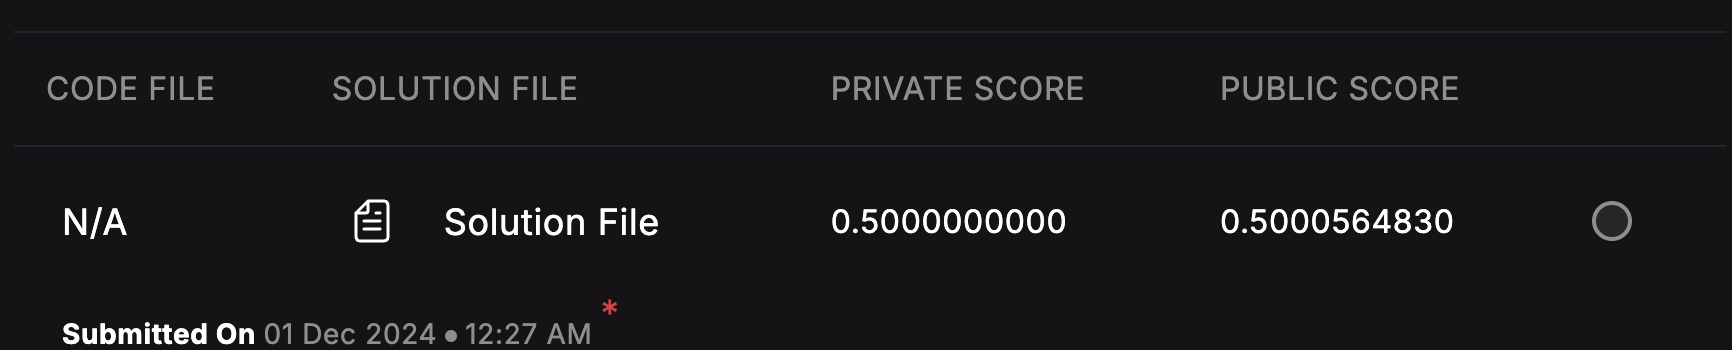

### pickling the model

In [354]:
joblib.dump(model_pipeline,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']

### perform oversampling to balance the dataset

In [356]:
over_sampling = RandomOverSampler()

In [357]:
train_y.value_counts()

Response
0           267700
1            37187
Name: count, dtype: int64

In [358]:
train_X_os, train_y_os = over_sampling.fit_resample(train_X,train_y)

In [359]:
train_y_os.value_counts()

Response
0           267700
1           267700
Name: count, dtype: int64

### Using GridSearch to hyper tune multi model

In [361]:
params_2 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [100, 200],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    }
]

In [362]:
params_2

[{'model': [LogisticRegression()],
  'model__penalty': ['l2', None],
  'model__C': [0.5, 3],
  'model__solver': ['saga']},
 {'model': [RandomForestClassifier()],
  'model__n_estimators': [100, 200],
  'model__max_depth': [10, 20],
  'model__min_samples_split': [2, 5]}]

In [377]:
grid_2 = GridSearchCV(estimator=model_pipeline, param_grid=params_2, 
                    cv=2, scoring='roc_auc')

In [379]:
grid_2.fit(train_X_os, train_y_os)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                                       ('model', LogisticRegression())]),
             param_grid=[{'model': [LogisticRegression()], 'model__C': [0.5, 3],
                          'model__penalty': ['l2', None],
                          'model__solver': ['saga']},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [10, 20],
                          'model__min_samples_split': [2, 5],
                          'model__n_estimators': [100, 200]}],
             scoring='roc_auc')

In [380]:
grid_2.best_params_

{'model': RandomForestClassifier(),
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

In [381]:
grid_2.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])

In [382]:
grid_2.cv_results_

{'mean_fit_time': array([ 6.40869212,  1.15938282,  1.04745483,  1.18906701, 11.14694417,
        21.54971099, 11.12842655, 21.47983861, 16.36890304, 32.80816293,
        16.57029104, 32.33231199]),
 'std_fit_time': array([0.05345392, 0.02915645, 0.04137015, 0.12684023, 0.14604604,
        0.45618296, 0.0810194 , 0.52614379, 0.21593606, 0.35965085,
        0.05077887, 0.00372612]),
 'mean_score_time': array([0.17131257, 0.17502177, 0.17931569, 0.18048942, 1.23948288,
        2.30198407, 1.25813985, 2.31384599, 2.47796845, 4.6644845 ,
        2.47499645, 4.65975463]),
 'std_score_time': array([0.00519943, 0.01207793, 0.00270236, 0.00123966, 0.03814602,
        0.01218009, 0.01516414, 0.03642714, 0.01400256, 0.06973147,
        0.01848352, 0.03724754]),
 'param_model': masked_array(data=[LogisticRegression(), LogisticRegression(),
                    LogisticRegression(), LogisticRegression(),
                    RandomForestClassifier(), RandomForestClassifier(),
                    Ran

In [383]:
new_model = grid_2.best_estimator_

Train Accuracy : 
0.7924870525801363
Test Accuracy : 
0.7519876151242424
Train AUC
0.880140048881563
Valid AUC
0.7825851080938335
Train cnf_matrix
[[204578  63122]
 [   146  37041]]
Valid cnf_matrix
[[49477 17222]
 [ 1682  7841]]
Train cls_rep
              precision    recall  f1-score   support

           0       1.00      0.76      0.87    267700
           1       0.37      1.00      0.54     37187

    accuracy                           0.79    304887
   macro avg       0.68      0.88      0.70    304887
weighted avg       0.92      0.79      0.83    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     66699
           1       0.31      0.82      0.45      9523

    accuracy                           0.75     76222
   macro avg       0.64      0.78      0.65     76222
weighted avg       0.89      0.75      0.79     76222



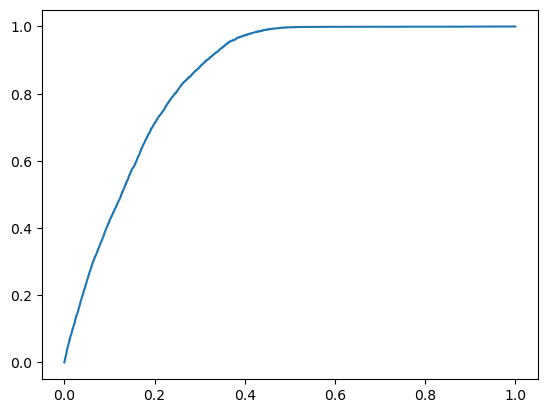

In [384]:
model_train_val_eval(train_X,val_X,train_y,val_y,new_model)

In [385]:
res_df_2 = pd.DataFrame(grid_2.cv_results_,)
pd.set_option('display.max_colwidth',100)
res_df_2[['params','mean_test_score','rank_test_score']]

params  \
0     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   
4   {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'mode...   
5   {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'mode...   
6   {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 5, 'mode...   
7   {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 5, 'mode...   
8   {'model': RandomForestClassifier(), 'model__max_depth': 20, 'model__min_samples_split': 2, 'mode...   
9   {'model': RandomForestClassifier(), 'model__max_depth': 20, 'model__min_samples_split': 2, 'mode...   
10  {'model': RandomForestClassifier(), 'model__max_depth': 20, 'model__min_samples_split': 5, 'mode...   
11  {'model': RandomForestClassifier(), 'model__max_depth': 20, 'model__min_samples_split': 5, 'mode...   

    mean_test_score  rank_test_score  
0          0.836383                9  
1          0.836383               11  
2          0.836383               12  
3          0.836383               10  
4          0.859168                6  
5          0.859230                5  
6          0.859102                8  
7          0.859107                7  
8          0.934791                2  
9          0.936299                1  
10         0.927941                4  
11         0.929254                3

In [386]:
sub['Response'] = new_model.predict(test)
sub.to_csv("sub_2.csv",index=False)
sub

id  Response
0       381110         0
1       381111         1
2       381112         1
3       381113         0
4       381114         0
...        ...       ...
127032  508142         0
127033  508143         1
127034  508144         0
127035  508145         0
127036  508146         0

[127037 rows x 2 columns]

### result uploaded in the analytics vidhya website and the recieved score

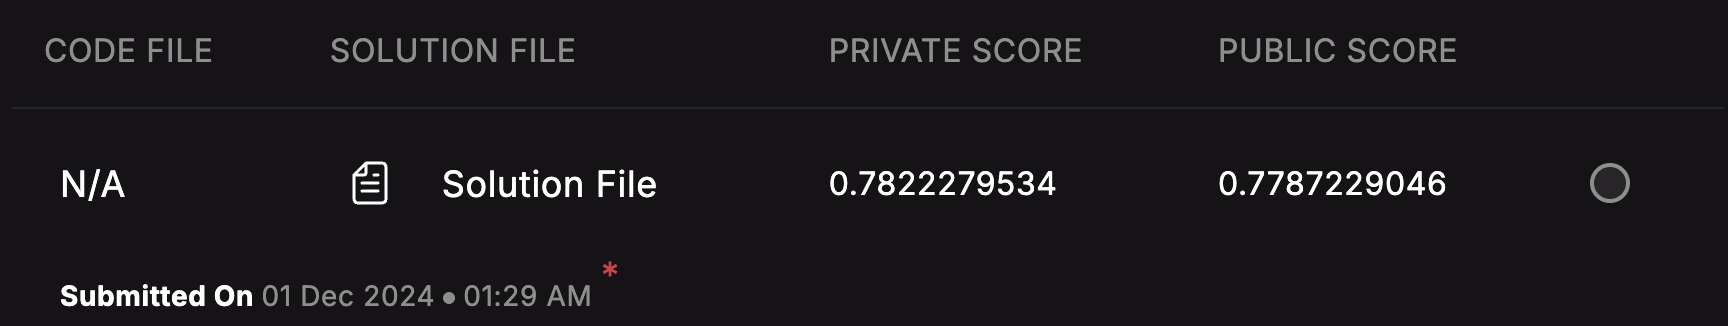

In [389]:
joblib.dump(new_model,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']

### Using GridSearch to hyper tune multi model along with ensembling

In [403]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier

In [405]:
params_3 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [100, 200],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    },
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',XGBClassifier(eval_metric='auc')],
        ['sclf2',GradientBoostingClassifier()],
        ['sclf3',AdaBoostClassifier()],],   
        final_estimator=LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.5)
    )],
    'model__sclf1__max_depth':[10,20],
    'model__sclf2__n_estimators':[15,25],    
    'model__sclf3__n_estimators':[5,35],    
    }
]

In [407]:
grid_3 = GridSearchCV(estimator=model_pipeline, param_grid=params_3, 
                    cv=3, scoring='roc_auc')

In [409]:
grid_3.fit(train_X_os, train_y_os)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...
                                                                                  n_estimators=None,
                                                                                  n_jobs=None,
                                                                                  num_parallel_tree=None,
                                                                                  random_state=None, ...)],
                                                                   ['sclf2',
                                                                    GradientBoostingClassifier()],
                                                                   ['sclf3',
                                                                    AdaBoostClassifier()]],
                                                       final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                                          penalty='elasticnet',
                                                                                          solver='saga'))],
                          'model__sclf1__max_depth': [10, 20],
                          'model__sclf2__n_estimators': [15, 25],
                          'model__sclf3__n_estimators': [5, 35]}],
             scoring='roc_auc')

In [410]:
grid_3.best_params_

{'model': StackingClassifier(estimators=[['sclf1',
                                 XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='auc',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                 

In [411]:
grid_3.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   St...
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)],
                                                ['sclf2',
                                                 GradientBoostingClassifier(n_estimators=25)],
                                                ['sclf3',
                                                 AdaBoostClassifier(n_estimators=5)]],
                                    final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                       penalty='elasticnet',
                                                                       solver='saga')))])

In [412]:
new_model_3 = grid_3.best_estimator_

Train Accuracy : 
0.9986257203488506
Test Accuracy : 
0.859541864553541
Train AUC
0.9966934479063045
Valid AUC
0.5569336412530882
Train cnf_matrix
[[267499    201]
 [   218  36969]]
Valid cnf_matrix
[[64054  2645]
 [ 8061  1462]]
Train cls_rep
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267700
           1       0.99      0.99      0.99     37187

    accuracy                           1.00    304887
   macro avg       1.00      1.00      1.00    304887
weighted avg       1.00      1.00      1.00    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66699
           1       0.36      0.15      0.21      9523

    accuracy                           0.86     76222
   macro avg       0.62      0.56      0.57     76222
weighted avg       0.82      0.86      0.83     76222



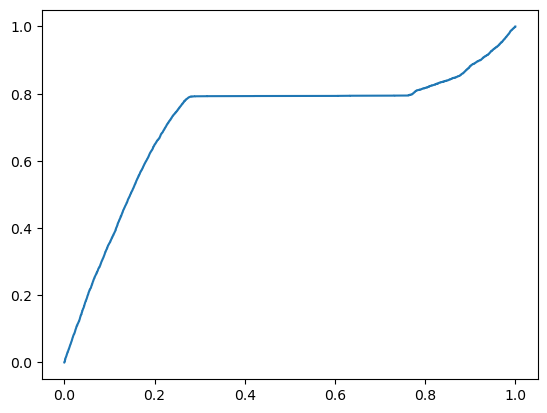

In [413]:
model_train_val_eval(train_X,val_X,train_y,val_y,new_model_3)

In [414]:
res_df_3 = pd.DataFrame(grid_3.cv_results_,)
pd.set_option('display.max_colwidth',500)
res_df_3[['params','mean_test_score','rank_test_score']]

params  \
0                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   
4                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}   
5                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}   
6                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}   
7                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 

In [415]:
# updating the existing target values with predicted values
sub['Response'] = new_model_3.predict(test)
sub.to_csv('sub_3.csv',index=False)

### result uploaded in the analytics vidhya website and the recieved score

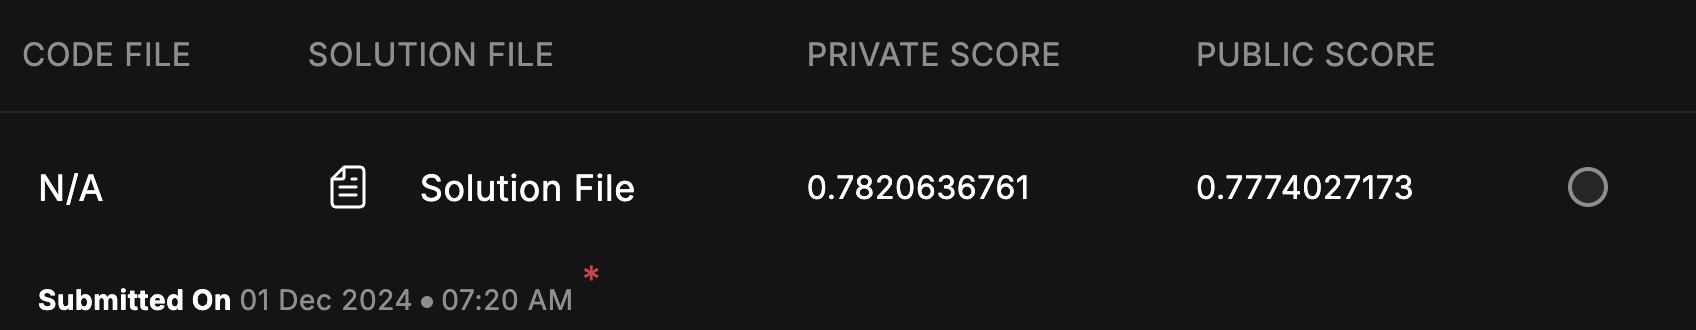

In [416]:
joblib.dump(new_model_3,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']

### Using GridSearch to hyper tune multi model along with ensembling

In [418]:
params_4 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [100, 200],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    },
    {
    'model': [DecisionTreeClassifier()],
    'model__max_depth':[10,15,20],
    'model__criterion':['gini'],
    'model__max_features':[None, 'sqrt', 'log2']
    },
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',XGBClassifier(eval_metric='auc')],
        ['sclf2',GradientBoostingClassifier()],
        ['sclf3',AdaBoostClassifier()],
        ['sclf4',LGBMClassifier(eval_metric='auc')],],   
        final_estimator=LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.5)
    )],
    'model__sclf1__max_depth':[10,20],
    'model__sclf2__n_estimators':[15,25],    
    'model__sclf3__n_estimators':[5,35],
    'model__sclf4__n_estimators':[25,50],
    }
]

In [419]:
grid_4 = GridSearchCV(estimator=model_pipeline, param_grid=params_4, 
                    cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [420]:
grid_4.fit(train_X_os, train_y_os)

Fitting 5 folds for each of 37 candidates, totalling 185 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l2, model__solver=saga; total time=  23.2s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=2, model__n_estimators=100; total time=  47.8s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=2, model__n_estimators=200; total time= 1.6min
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=sqrt; total time=   1.5s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l2, model__solver=saga; total time=  23.1s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=2, model__n_estimators=100; t

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=None; total time=   3.3s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=sqrt; total time=   1.6s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=log2; total time=   1.9s
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise mu

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032548 seconds.
You can 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when 

 used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

                                            multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()],
                               ['sclf4', LGBMClassifier(eval_metric='auc')]],
                   final_estimator=LogisticRegression(l1_ratio=0.5,
                                                      penalty='elasticnet',
                                                      solver='saga')), model__sclf1__max_depth=10, model__sclf2__n_estimators=15, model__sclf3__n_estimators=35, model__sclf4__n_estimators=25; total time= 2.3min
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 2141

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   3.3s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   3.5s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   2.9s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  32.1s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  32.7s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  46.9s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.6min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   3.8s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   4.0s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   3.4s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  32.4s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  33.8s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  47.5s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.7min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   3.6s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   4.0s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   3.9s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  32.9s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  33.1s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  47.5s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.7min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   3.8s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   3.4s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   3.3s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  33.0s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  33.1s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  48.0s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.7min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_b

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:BoostFromSco

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...
                                                                    GradientBoostingClassifier()],
                                                                   ['sclf3',
                                                                    AdaBoostClassifier()],
                                                                   ['sclf4',
                                                                    LGBMClassifier(eval_metric='auc')]],
                                                       final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                                          penalty='elasticnet',
                                                                                          solver='saga'))],
                          'model__sclf1__max_depth': [10, 20],
                          'model__sclf2__n_estimators': [15, 25],
                          'model__sclf3__n_estimators': [5, 35],
                          'model__sclf4__n_estimators': [25, 50]}],
             scoring='roc_auc', verbose=2)

In [421]:
grid_4.best_params_

{'model': StackingClassifier(estimators=[['sclf1',
                                 XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='auc',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                 

In [422]:
grid_4.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   St...
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...)],
                                                ['sclf2',
                                                 GradientBoostingClassifier(n_estimators=25)],
                                                ['sclf3',
                                                 AdaBoostClassifier(n_estimators=35)],
                                                ['sclf4',
                                                 LGBMClassifier(eval_metric='auc',
                                                                n_estimators=50)]],
                                    final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                       penalty='elasticnet',
                                                                       solver='saga')))])

In [423]:
new_model_4 = grid_4.best_estimator_

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Train Accuracy : 
0.9986421198673607
Test Accuracy : 
0.859397549263992
Train AUC
0.9966101643463174
Valid AUC
0.5530254928638304
Train cnf_matrix
[[267512    188]
 [   226  36961]]
Valid cnf_matrix
[[64128  2571]
 [ 8146  1377]]
Train cls_rep
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    267700
           1       0.99      0.99      0.99     37187

    accuracy                           1.00    304887
   macro avg       1.00      1.00      1.00    304887
weighted avg       1.00      1.00      1.00    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66699
           1       0.35      0.14      0.20      9523

    accuracy                           0.86     76222
   macro avg       0.62      0.55      0.56     76222
weighted avg       0.82      0.86      

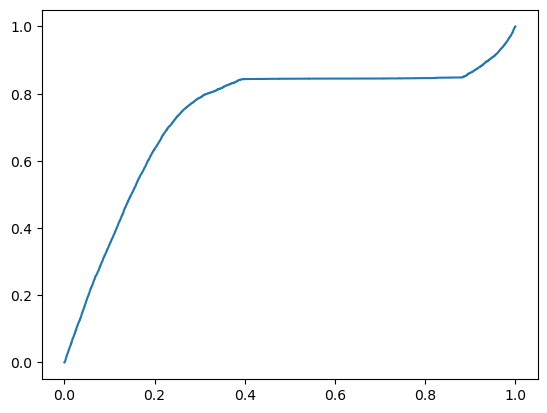

In [424]:
model_train_val_eval(train_X,val_X,train_y,val_y,new_model_4)

In [425]:
res_df_4 = pd.DataFrame(grid_4.cv_results_,)
pd.set_option('display.max_colwidth',500)
res_df_4[['params','mean_test_score','rank_test_score']]

params  \
0                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   
4                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}   
5                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}   
6                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}   
7                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 

In [426]:
# updating the existing target values with predicted values
sub['Response'] = new_model_4.predict(test)
sub.to_csv('sub_4.csv',index=False)

[LightGBM] [Warning] Unknown parameter: eval_metric


### result uploaded in the analytics vidhya website and the recieved score

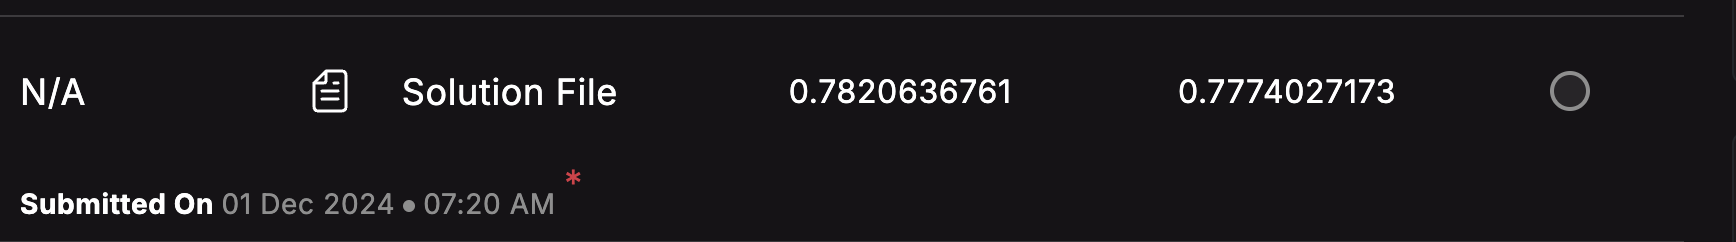

In [429]:
joblib.dump(new_model_4,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']

### Using GridSearch to hyper tune multi model along with ensembling

In [431]:
params_5 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [100, 200],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    },
    {
    'model': [DecisionTreeClassifier()],
    'model__max_depth':[10,15,20],
    'model__criterion':['gini'],
    'model__max_features':[None, 'sqrt', 'log2']
    },
    {
    'model': [LogisticRegression()],
    'model__penalty':['l1'],
    'model__C':[0.5,3],
    'model__solver':['liblinear']
    },
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',XGBClassifier(eval_metric='auc')],
        ['sclf2',GradientBoostingClassifier()],
        ['sclf3',AdaBoostClassifier()],
        ['sclf4',LGBMClassifier(eval_metric='auc')],
        ['sclf5',CatBoostClassifier(eval_metric='auc')],],   
        final_estimator=LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.5)
    )],
    'model__sclf1__max_depth':[10,20],
    'model__sclf2__n_estimators':[15,25],    
    'model__sclf3__n_estimators':[5,35],
    'model__sclf4__n_estimators':[25,50],
    'model__sclf5__n_estimators':[50,100],
    }
]

In [432]:
grid_5 = GridSearchCV(estimator=model_pipeline, param_grid=params_5, 
                    cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [433]:
grid_5.fit(train_X_os, train_y_os)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/pyt

[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:Boo

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 342656, numbe

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightG

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 342656, number of used features: 14
[LightGBM] [Info] [binary:Boo

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 428320, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 171328, number of negative: 171328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 3

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...
                                                                    <catboost.core.CatBoostClassifier object at 0x31f9258b0>]],
                                                       final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                                          penalty='elasticnet',
                                                                                          solver='saga'))],
                          'model__sclf1__max_depth': [10, 20],
                          'model__sclf2__n_estimators': [15, 25],
                          'model__sclf3__n_estimators': [5, 35],
                          'model__sclf4__n_estimators': [25, 50],
                          'model__sclf5__n_estimators': [50, 100]}],
             scoring='roc_auc', verbose=2)

In [434]:
grid_5.best_params_

{'model': RandomForestClassifier(),
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

In [435]:
grid_5.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=200))])

In [436]:
new_model_5 = grid_5.best_estimator_

Train Accuracy : 
0.7924542535431159
Test Accuracy : 
0.7511217233869486
Train AUC
0.880086637867823
Valid AUC
0.7820003318552217
Train cnf_matrix
[[204571  63129]
 [   149  37038]]
Valid cnf_matrix
[[49413 17286]
 [ 1684  7839]]
Train cls_rep
              precision    recall  f1-score   support

           0       1.00      0.76      0.87    267700
           1       0.37      1.00      0.54     37187

    accuracy                           0.79    304887
   macro avg       0.68      0.88      0.70    304887
weighted avg       0.92      0.79      0.83    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     66699
           1       0.31      0.82      0.45      9523

    accuracy                           0.75     76222
   macro avg       0.64      0.78      0.65     76222
weighted avg       0.89      0.75      0.79     76222



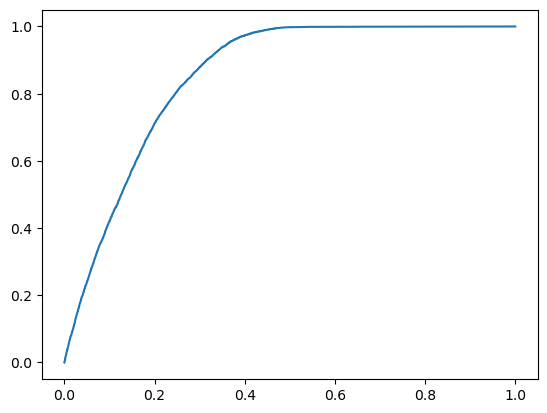

In [437]:
model_train_val_eval(train_X,val_X,train_y,val_y,new_model_5)

In [438]:
res_df_5 = pd.DataFrame(grid_5.cv_results_,)
pd.set_option('display.max_colwidth',500)
res_df_5[['params','mean_test_score','rank_test_score']]

params  \
0                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   
4                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}   
5                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}   
6                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 100}   
7                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 

In [439]:
# updating the existing target values with predicted values
sub['Response'] = new_model_5.predict(test)
sub.to_csv('sub_5.csv',index=False)

### result uploaded in the analytics vidhya website and the recieved score

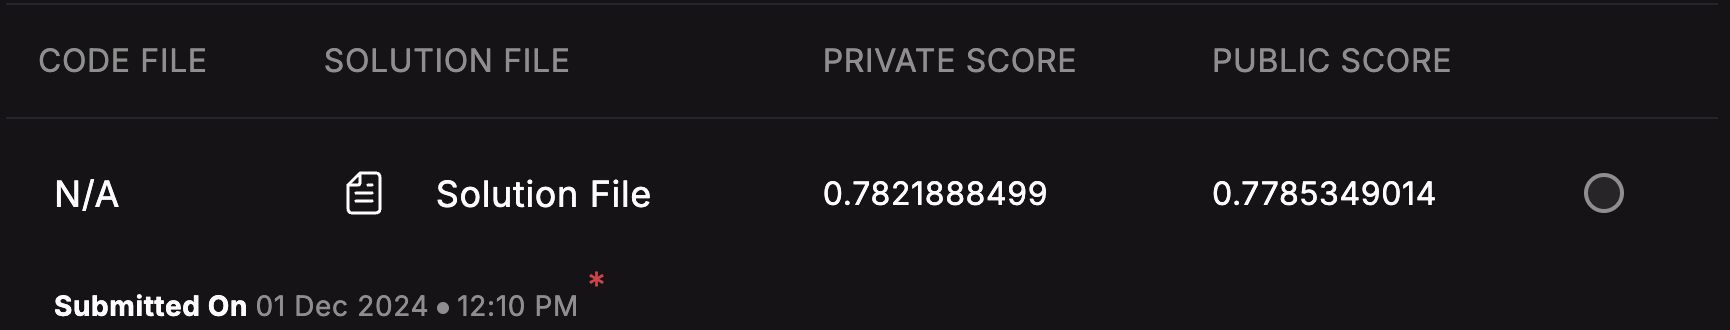

In [442]:
joblib.dump(new_model_5,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']

### Using GridSearch to hyper tune multi model along with ensembling

In [444]:
params_6 = [
    {
    'model': [LogisticRegression()],
    'model__penalty':['l2',None],
    'model__C':[0.5,3],
    'model__solver':['saga']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [100, 200],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    },
    {
    'model': [DecisionTreeClassifier()],
    'model__max_depth':[10,15,20],
    'model__criterion':['gini'],
    'model__max_features':[None, 'sqrt', 'log2']
    },
    {
    'model': [LogisticRegression()],
    'model__penalty':['l1'],
    'model__C':[0.5,3],
    'model__solver':['liblinear']
    },
    {
    'model': [RandomForestClassifier()],
    'model__n_estimators': [250],
    'model__max_depth':[10,20],
    'model__min_samples_split': [2, 5]   
    },
    {
    'model': [StackingClassifier(
    estimators=[
        ['sclf1',XGBClassifier(eval_metric='auc')],
        ['sclf2',GradientBoostingClassifier()],
        ['sclf3',AdaBoostClassifier()],
        ['sclf4',LGBMClassifier(eval_metric='auc')],
        ['sclf5',CatBoostClassifier(eval_metric='auc')],
        ['sclf6',RandomForestClassifier()],],   
        final_estimator=LogisticRegression(penalty='elasticnet',solver='saga', l1_ratio=0.5)
    )],
    'model__sclf1__max_depth':[10,20],
    'model__sclf2__n_estimators':[15,25],    
    'model__sclf3__n_estimators':[5,35],
    'model__sclf4__n_estimators':[25,50],
    'model__sclf5__n_estimators':[50,100],
    'model__sclf6__n_estimators':[100,150],
    }
]

In [445]:
grid_6 = GridSearchCV(estimator=model_pipeline, param_grid=params_6, 
                    cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [446]:
grid_6.fit(train_X_os, train_y_os)

Fitting 5 folds for each of 91 candidates, totalling 455 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=None; total time=   2.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=sqrt; total time=   1.3s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=sqrt; total time=   1.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.3s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=None; total time=   3.0s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.3s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.6s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=sqrt; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=None; total time=   2.9s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=sqrt; total time=   1.6s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=log2; total time=   1.4s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l1, model__solver=liblin

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=sqrt; total time=   1.1s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.6s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=sqrt; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=None; total time=   3.0s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=sqrt; total time=   1.6s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=log2; total time=   1.6s
[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=l1, model__solver=liblin

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=sqrt; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=sqrt; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.4s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=None; total time=   2.9s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model__max_features=sqrt; total time=   1.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


s=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learni...
                            

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when 

[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=None; total time=   2.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=sqrt; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=10, model__max_features=log2; total time=   1.2s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=None; total time=   2.7s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=sqrt; total time=   1.5s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=15, model__max_features=log2; total time=   1.3s
[CV] END model=DecisionTreeClassifier(), model__criterion=gini, model__max_depth=20, model

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   4.0s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   4.7s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   3.6s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  32.4s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  34.2s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  47.6s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.5min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV] END model=LogisticRegression(), model__C=0.5, model__penalty=None, model__solver=saga; total time=   4.7s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=l2, model__solver=saga; total time=   3.5s
[CV] END model=LogisticRegression(), model__C=3, model__penalty=None, model__solver=saga; total time=   2.7s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=  32.5s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=  34.3s
[CV] END model=RandomForestClassifier(), model__max_depth=10, model__min_samples_split=5, model__n_estimators=200; total time= 1.1min
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=100; total time=  47.5s
[CV] END model=RandomForestClassifier(), model__max_depth=20, model__min_samples_split=5, model__n_estimators=200; total time= 1.5min
[Li

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


             ['sclf3', AdaBoostClassifier()],
                               ['sclf4', LGBMClassifier(eval_metric='auc')],
                               ['sclf5',
                               ['sclf6', RandomForestClassifier()]],
                   final_estimator=LogisticRegression(l1_ratio=0.5,
                                                      penalty='elasticnet',
                                                      solver='saga')), model__sclf1__max_depth=10, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5, model__sclf4__n_estimators=50, model__sclf5__n_estimators=100, model__sclf6__n_estimators=150; total time=  25.6s
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 214160, number of negative: 214160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


     learni...
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)],
                               ['sclf2', GradientBoostingClassifier()],
                               ['sclf3', AdaBoostClassifier()],
                               ['sclf4', LGBMClassifier(eval_metric='auc')],
                               ['sclf5',
                               ['sclf6', RandomForestClassifier()]],
                   final_estimator=LogisticRegression(l1_ratio=0.5,
                                                      penalty='elasticnet',
                                                      solver='saga')), model__sclf1__max_depth=20, model__sclf2__n_estimators=15, model__sclf3__n_estimators=5, model__sclf4__n_estimators=25, model__sclf5__n_estimators=50, model__sclf6__n_estimators=150; total time=  26.6s
[LightGBM] [Warning] Unkn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


de=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learni...
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)],
                               ['sclf2', GradientBoostingClassifier()],
                  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

[CV] END model=StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                         

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_encode',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                                        ('num_encode',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer(str...
                                                                    RandomForestClassifier()]],
                                                       final_estimator=LogisticRegression(l1_ratio=0.5,
                                                                                          penalty='elasticnet',
                                                                                          solver='saga'))],
                          'model__sclf1__max_depth': [10, 20],
                          'model__sclf2__n_estimators': [15, 25],
                          'model__sclf3__n_estimators': [5, 35],
                          'model__sclf4__n_estimators': [25, 50],
                          'model__sclf5__n_estimators': [50, 100],
                          'model__sclf6__n_estimators': [100, 150]}],
             scoring='roc_auc', verbose=2)

In [447]:
grid_6.best_params_

{'model': RandomForestClassifier(),
 'model__max_depth': 20,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

In [448]:
grid_6.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')),
                                                 ('num_encode',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=250))])

In [449]:
new_model_6 = grid_6.best_estimator_

Train Accuracy : 
0.7916703565583314
Test Accuracy : 
0.7508068536642964
Train AUC
0.8798602207830089
Valid AUC
0.7819104353101337
Train cnf_matrix
[[204313  63387]
 [   130  37057]]
Valid cnf_matrix
[[49387 17312]
 [ 1682  7841]]
Train cls_rep
              precision    recall  f1-score   support

           0       1.00      0.76      0.87    267700
           1       0.37      1.00      0.54     37187

    accuracy                           0.79    304887
   macro avg       0.68      0.88      0.70    304887
weighted avg       0.92      0.79      0.83    304887

Valid cls rep
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     66699
           1       0.31      0.82      0.45      9523

    accuracy                           0.75     76222
   macro avg       0.64      0.78      0.65     76222
weighted avg       0.89      0.75      0.79     76222



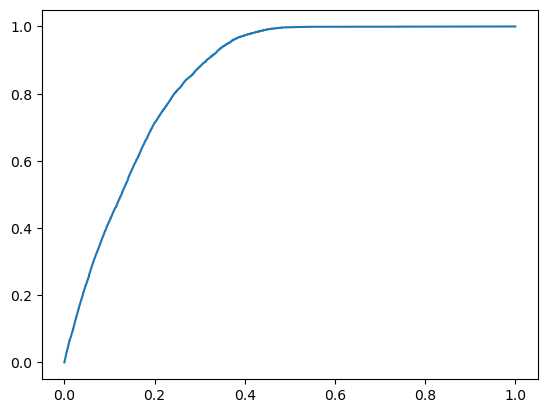

In [450]:
model_train_val_eval(train_X,val_X,train_y,val_y,new_model_6)

In [451]:
res_df_6 = pd.DataFrame(grid_6.cv_results_,)
pd.set_option('display.max_colwidth',500)
res_df_6[['params','mean_test_score','rank_test_score']]

params  \
0                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': 'l2', 'model__solver': 'saga'}   
1                                                                                                                                                                                                                                                                                                                                                                                                                     {'model': LogisticRegression(), 'model__C': 0.5, 'model__penalty': None, 'model__solver': 'saga'}   
2                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'saga'}   
3                                                                                                                                                                                                                                                                                                                                                                                                                       {'model': LogisticRegression(), 'model__C': 3, 'model__penalty': None, 'model__solver': 'saga'}   
4                                                                                                                                                                                                                                                                                                                                                                                                {'model': RandomForestClassifier(), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}   
..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ...   
86  {'model': StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                       ...   
87  {'model': StackingClassifier(estimators=[['sclf1',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                       

In [452]:
# updating the existing target values with predicted values
sub['Response'] = new_model_6.predict(test)
sub.to_csv('sub_6.csv',index=False)

### result uploaded in the analytics vidhya website and the recieved score

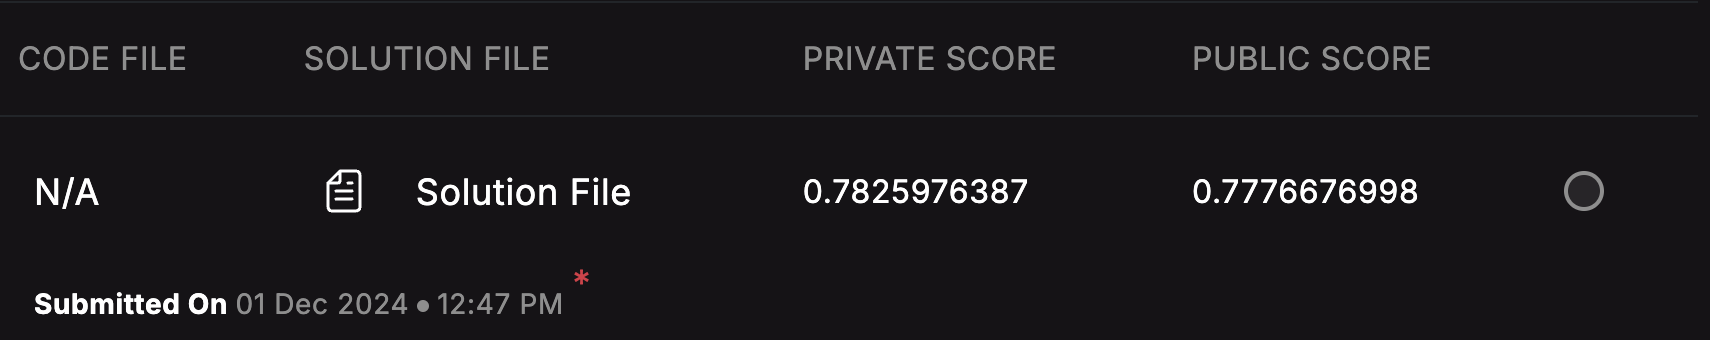

In [495]:
joblib.dump(new_model_6,'janatahackcrosssell_pipeline_model.pkl')

['janatahackcrosssell_pipeline_model.pkl']